In [158]:
import tensorflow as tf
import collections
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import gridspec
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Import functions in lib folder
import sys
sys.path.insert(1, 'lib')
%load_ext autoreload
%autoreload 2
from lib.utils import count_segments, extract_features, load_data, all_features, get_el_names, dog_patient_plot
from lib.utils import feature_distrib, feature_distrib_all, extract_ar_param, band_distrib_all, train_classifier_ALL
from lib.utils import all_ar_param, extract_fft_features, test_classifier, all_fft_feats, feature_band_distrib
from lib.utils import train_classifier

# Math
import math
import numpy as np
from numpy.fft import fft
import scipy as sp
from scipy import io as sio
import statsmodels.api as sm
# Time
import time
# Classification
import sklearn.neighbors, sklearn.linear_model, sklearn.ensemble, sklearn.naive_bayes 
from sklearn.feature_selection import SelectKBest
# Folder exploration
import os
import glob
# Data management
import pandas as pd
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Epileptic seizure prediction

Sophie du Bois

## 1. Introduction
This project is based on the [Kaggle competition](https://www.kaggle.com/c/seizure-prediction/) _American Epilepsy Society Seizure Prediction Challenge_, that took place in 2014. The goal is to predict the onset of epileptic seizures from intracranial electroencephalogram (iEEG) measurements. If seizures can be predicted, then patients can be warned. This could allow them to avoid dangerous activities (driving, swimming, ...) when a seizure is likely to happen. Those warnings could also help them decrease their medication uptake, as it may be possible to take drugs only when needed.

Brain activity of epileptic patients can be divided into _interictal_ (between seizures), _preictal_ (before seizures), _ictal_ (seizures) and _post-ictal_ (after seizures) segments. The goal of the competition was to classify 10 minutes long iEEG recordings between _interictal_ and _preictal_ classes. Data was recorded from both dogs and human patients.

<figure>
    <img src="DogRecordingSystem.png" style="width: 500px;"/>
    <figcaption> Fig.1 Overview of experimental setup and recorded data. </figcaption>
    <cite>From Kaggle competition description</cite>
</figure>


### Acknowledgements

This competition was sponsored by the National Institutes of Health (NINDS), the Epilepsy Foundation, and the American Epilepsy Society. Data was made available by the [IEEG portal](ieeg.org).




## 2. Data acquisition

Data can be downloaded from the competition webpage, and is in .mat format. In addition to the EEG recordings, the time duration in seconds, the sampling frequency, and the names of the channels are provided for each segment.


File 'Dog_3_test_segment_0133.mat' seemed to be corrupted, as it could not be opened either in Python or Matlab. It was therefore discarded.

### Dogs vs patients data
Data comes from 5 dogs (Dog_1 to Dog_5), and 2 patients (Patient_1 and Patient_2). From the competition description, one learns that 16 electrodes were used in dogs, with a sampling frequency of 400 Hz, and that all the channels were referenced to the group average. In patients, a various number of electrodes was used, with a sampling frequency of 5 kHz, and the channels were referenced to an eletrode located outside of the brain.

In order to visualize the difference between, a channel of an arbitralily chosen segment is displayed for each of the species. Dog recording is shifted up, to improve visibility.

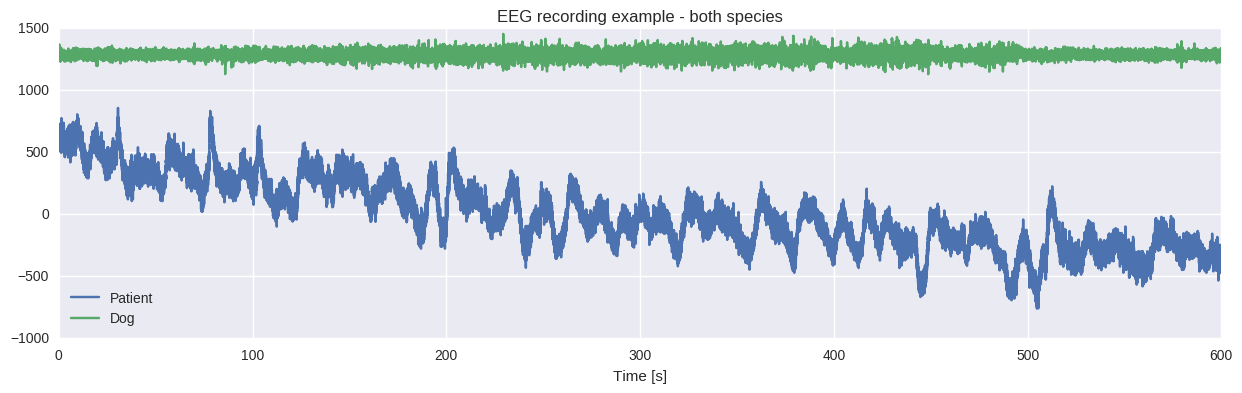

In [2]:
# Select two datapoints, one coming from a patient, the other one from a dog
matDog = sp.io.loadmat('Data/Dog_3/Dog_3_interictal_segment_0011.mat')
matPat = sp.io.loadmat('Patient_1/Patient_1_interictal_segment_0027.mat')

# Choose arbitrarily one eletrode to look at
chan = 2

dog_patient_plot(matDog,matPat,chan)

In the graph above, EEG recorded in Dog_3 seems to have a relatively constant mean, while there is a lot of drift in the patient recording. It is hard to tell whether this drift comes from the referencing, or from some un-mentioned pre-processing of the dog data.

The cumulation of the sampling frequency difference, the varying number of electrodes, and the drift highlighted by the above plot make patient data harder to work with. Additional pre-processing would be required to treat those recordings, and they were thus left out of the analysis in a first phase.

## 3. Data exploration

Each 10 minutes long EEG segment is given in a separate .mat file, the name of which contains either _interictal_, _preictal_, or _test_. Segments labelled _interictal_ are located as far as possible from any seizure event, while _preictal_ ones were recorded less than one hour before an epileptic seizure. The keyword _test_ indicates unlabelled data.


### Repartition between classes
Overall, there are approximately the same amount of unlabelled segments (test set) than of labelled ones (training set). In the training set, there are approximately ten times more interictal segments than preictal ones. The dataset is strongly unbalanced, but this should also be the case in real life application.


In:  /home/osboxes/Documents/NetworkTourDataScience/Project/Data  :
Interictal:  2932
Preictal:  229
Test:  3127
Total:  6288


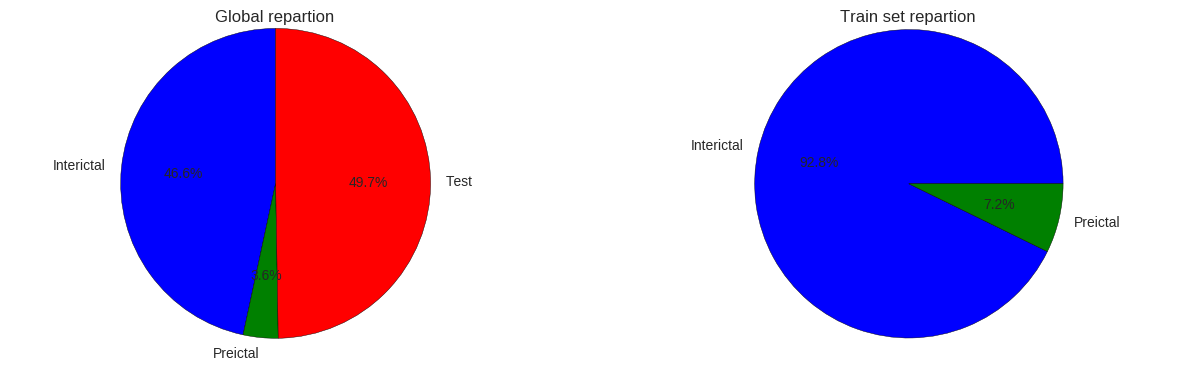

In [151]:
os.chdir("Data/")
seg_qty = count_segments()
os.chdir("../")
print('Total: ', np.sum(seg_qty))

categories = ['Interictal','Preictal','Test']

# Figure
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].pie(seg_qty, labels=categories, autopct='%1.1f%%', startangle=90);
axes[0].axis('equal');
axes[0].set_title('Global repartion');

axes[1].pie(seg_qty[0:2], labels=categories[0:2], autopct='%1.1f%%', startangle=0);
axes[1].axis('equal');
axes[1].set_title('Train set repartion');

### Electrode number
In principle, 16 electrodes were used to record the dog EEG signals. However, it is possible that some channels are missing, due to recording issues. The electrodes names were extracted from all the different datapoints, and counted.

In [17]:
dataDir = 'Data/'
N_EL,nameEL_TOT = get_el_names(dataDir)

All electrodes names: 
 ['c001' 'c002' 'c003' 'c004' 'c005' 'c006' 'c007' 'c008' 'c009' 'c010'
 'c011' 'c012' 'c013' 'c014' 'c015' 'c016']
Counts of each name: 
 [6288 6288 6288 5617 6288 6288 6288 6288 6288 6288 6288 6288 6288 6288 6288
 6288]


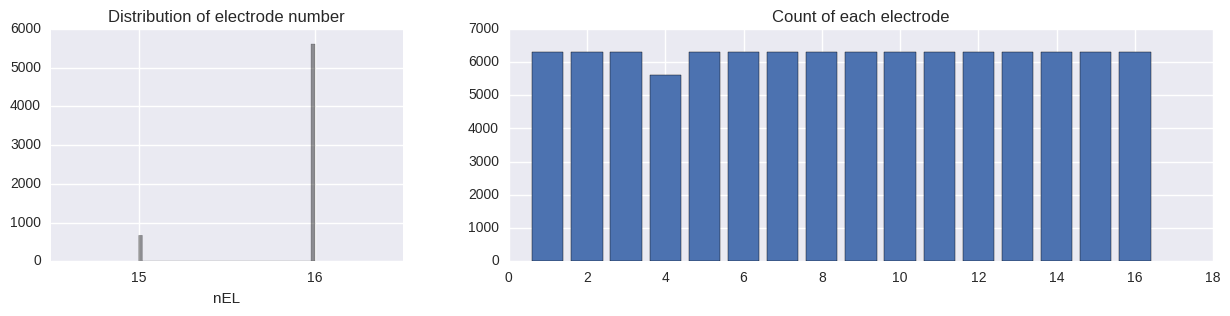

In [21]:
U,Ucounts = np.unique(nameEL_TOT, return_counts=True)
print('All electrodes names: \n', U)
print('Counts of each name: \n', Ucounts)

n = len(N_EL)
idx =  range(0, n , 1) 
d = {'nEL' : pd.Series(N_EL, index=idx)}
df = pd.DataFrame(d)

# Plotting
fig = plt.figure(figsize=(15, 3)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 

ax0 = plt.subplot(gs[0])
g = sns.distplot(df['nEL'], kde=False, rug=False, ax=ax0, color='k');
g.set(title='Distribution of electrode number');
ax0.axis([14.5,16.5,0,6000])
ax0.set_xticks([15,16])
ax0.set_xticklabels(['15','16']);

ax1 = plt.subplot(gs[1])
pos = range(1,len(U)+1)
ax1.bar(pos, Ucounts, align='center')
ax1.set_title('Count of each electrode');

For the majority of datapoints, there are indeed 16 channels available. However, the $4^{th}$ electrode is missing from 671 recordings. They actually correspond to the recordings from Dog_5. This electrode might have been missing, broken, or recording noisy signals.

### Example data point
One datapoint consists of a 10 minutes long, 16 channels recording. It can be visualized as follow:

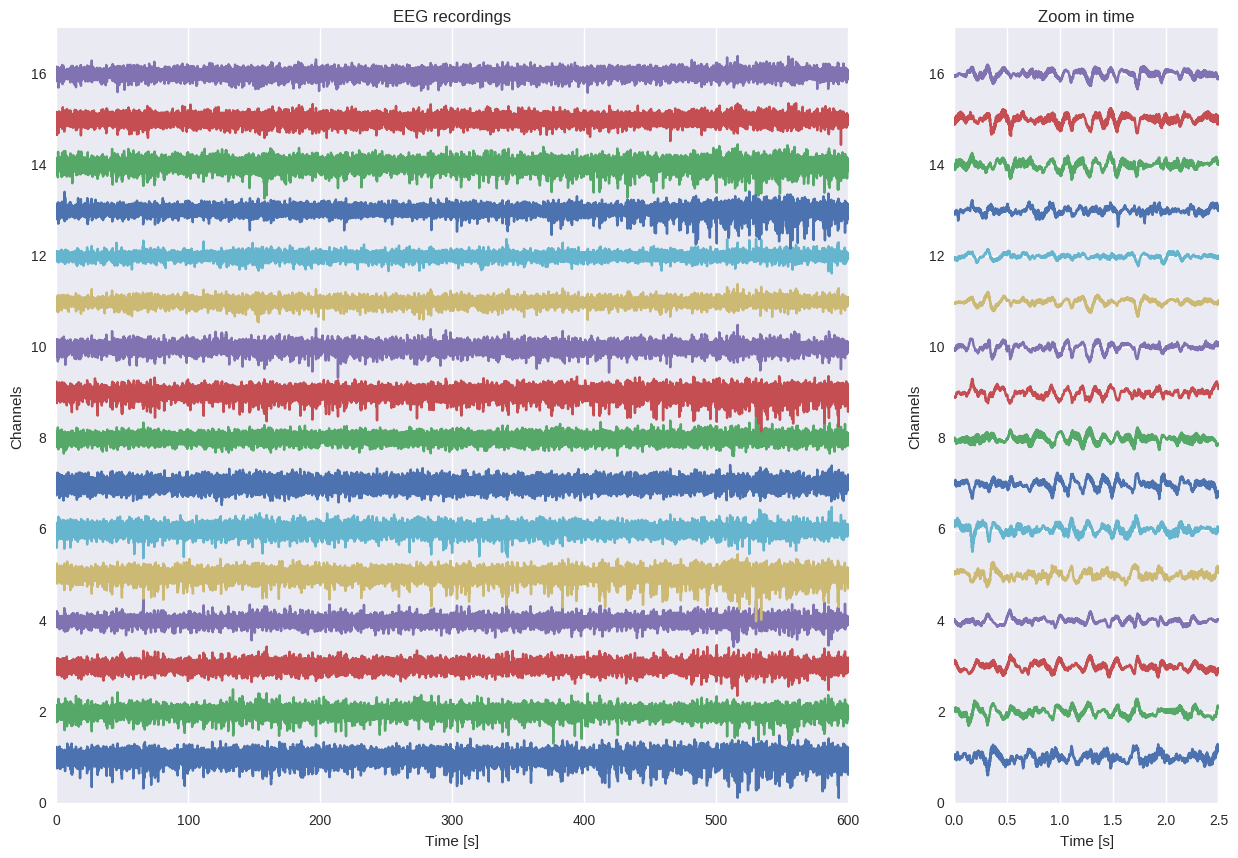

In [21]:
# Select a data point
mats = sp.io.loadmat('Data/Dog_4/Dog_4_preictal_segment_0007.mat') 
chan = 0
key = list(mats)
sub = 'segment'
segKey = [s for s in key if sub in s]

numRows = mats[segKey[0]][0][0][0].shape[0]
numSamples = len(mats[segKey[0]][0][0][0][chan])

# Get sampling rate
fs = mats[segKey[0]][0][0][2][0]
# Compute time array
t = range(0,numSamples)/fs

# Plotting
fig = plt.figure(figsize=(15, 10)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])

for i in range(numRows):
    data = mats[segKey[0]][0][0][0][i]
    plt.plot(t[::10],data[::10]/(2*np.max(data))+i+1)
ax0.set_title('EEG recordings');
ax0.set_xlabel('Time [s]');
ax0.set_ylabel('Channels');
ax0.axis([0,600.5,0,17]);

ax1 = plt.subplot(gs[1])
for i in range(numRows):
    data = mats[segKey[0]][0][0][0][i]
    plt.plot(t[:1000:1],data[:1000:1]/(2*np.max(data))+i+1)
ax1.set_title('Zoom in time');
ax1.set_xlabel('Time [s]');
ax1.set_ylabel('Channels');
ax1.axis([0,t[1000],0,17]);

No striking differences between interictal and preictal datapoints could be seen with the naked eye.

### Computing features from the time series

To highlight the difference between interictal and preictal segments, features were thus extracted from the time series:

* Amplitude, computed as mean(abs(x))
* Zero-crossing, a rough estimate of frequency
* Variance
* An estimate of the correlation time

#### Correlation time
The correlation time $\tau_C$ is usually defined as half of the integral of the autocorrelation function, from $-\infty$ to $\infty$. However, as in the data studied the autocorrelation function is negative in a non-negligible range, its aboslute value was used instead. Furthermore, as the autocorrelation function seems to be non-zero in a quite short range, the integral was truncated.

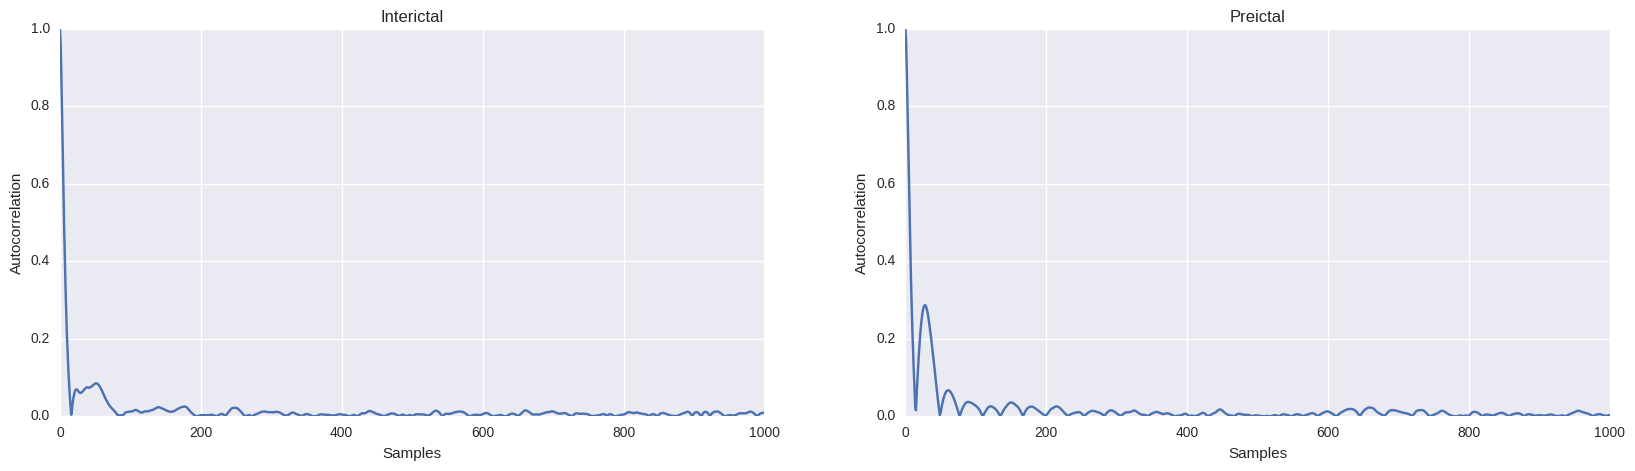

In [342]:
mats = []
mats.append(sp.io.loadmat('Data/Dog_4/Dog_4_interictal_segment_0032.mat'))
mats.append(sp.io.loadmat('Data/Dog_4/Dog_4_preictal_segment_0022.mat'))

chan = 0

axes = plt.subplots(figsize=(20, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
T = ['Interictal','Preictal']
for i in range(2):
    key = list(mats[i])
    sub = 'segment'
    segKey = [s for s in key if sub in s]
    data = mats[i][segKey[0]][0][0][0][chan]

    # Idx until which to integrate
    idx = int(500)
    
    a = data
    
    data_length = len(a)
    b = np.zeros(data_length * 2)
    h = int(round(data_length/2)) 
    b[h:h+data_length] = a

    # Do an array flipped convolution, which is a correlation.    
    c = signal.fftconvolve(b, a[::-1], mode='same') 

    #c2 = sm.tsa.stattools.acf(data, nlags=1000, fft=True)
    
    ax = plt.subplot(gs[i])
    x = abs(c[int(len(c)/2):int(len(c)/2)+1000])
    #x2 = abs(c2)
    plt.plot(x/max(x))
    ax.set_title(T[i]); ax.set_xlabel('Samples'); ax.set_ylabel('Autocorrelation');
    

For the selected segments, there is a clear difference in the autocorrelation function of the two classes. However, looking at only two segments is far from sufficient to assess the quality of a feature. Nonetheless, this measure seems worth a try.

#### Frequency ranges
To characterize signals, it is often informative to look at the frequencies components. Furthermore in EEG, the different frequencies present corresponds to distinct "neural oscillations". The most widely known band is called alpha wave (7.5–12.5 Hz). The other bands are: delta (1–4 Hz), theta (4–8 Hz), beta (13–30 Hz) and gamma (30–70 Hz) waves. In epilepsy, the brain activity in some of those bands may be disturbed. It is thus possible that preictal segments contain those "disturbances", while interictal segments would not.

The power spectral density (PSD) was computed, and integrated over those different ranges.


### Feature extraction - distribution
Features were extracted from all segments, and saved as byte streams using the _pickle_ module. This gains times, as the extraction is pretty lengthy.

#### Basic set

In [175]:
## Feature extraction

#dataDir = "Data/"
#featuresA,infoA,labelsA = all_features(dataDir)

#labels = np.hstack(labelsA)

#featuresTemp = (featuresA[0])
#for i in range(len(featuresA)-1):
#    featuresTemp = np.vstack((featuresTemp,featuresA[i+1]))
#featuresTemp.shape
#features = featuresTemp

#del featuresTemp, featuresA

In [177]:
## Saving the features using pickle

#with open('f_A_save', 'wb') as f:
#    pickle.dump(features, f)
#with open('labels_save', 'wb') as f:
#    pickle.dump(labels, f)
#with open('info_save', 'wb') as f:
#    pickle.dump(infoA, f)

In [4]:
# Loading the saved features

with open('f_A_save', 'rb') as f:
    features = pickle.load(f)
with open('labels_save', 'rb') as f:
    labels = pickle.load(f)
with open('info_save', 'rb') as f:
    info = pickle.load(f)

In [5]:
# Splitting train set (labelled) from test set (unlabelled)
idxTrain = np.where(labels!=3)
idxTest = np.where(labels==3)

X_train = np.squeeze(features[idxTrain,:])
X_test = np.squeeze(features[idxTest,:])
y_train = labels[idxTrain]
y_test = labels[idxTest]
info_train = [info[i] for i in idxTrain[0]]
info_test = [info[i] for i in idxTest[0]]

Once features are computed, it is possible to look at their distribution in the training set. First, let us consider the distribution across all subjects.

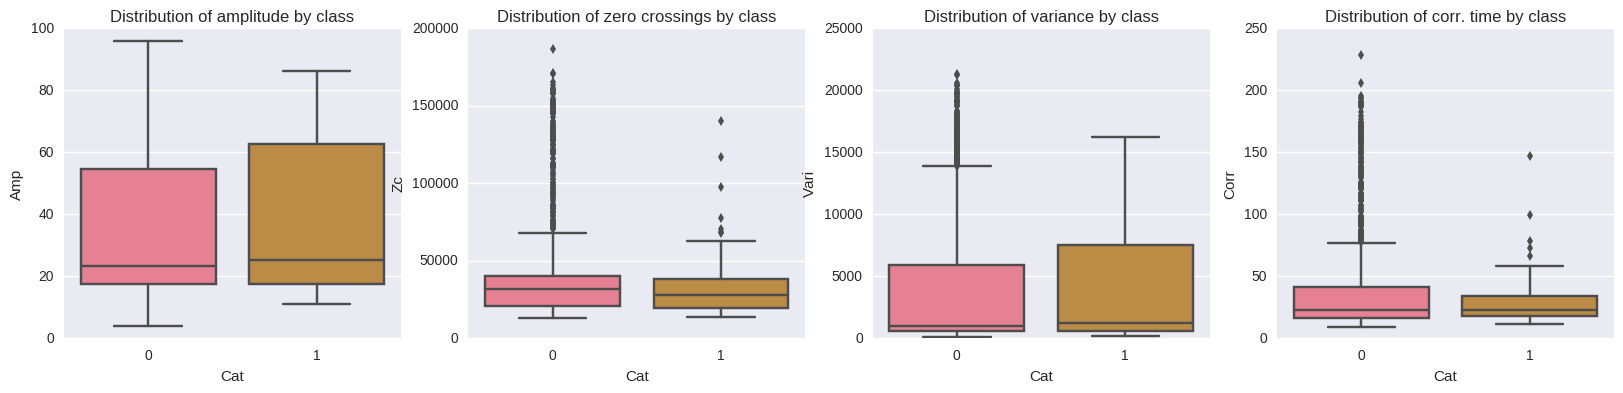

In [250]:
feature_distrib_all()

In the above graph, the distribution of the features is quite similar for both classes. This is a relatively bad sign, as it means that it will be almost impossible to distinguish inter- and pre-inctal segments from each others. It could mean that other features need to be thought of. However, it is also possible that there is an important variations of those features between the dogs, making the overall distribution quite uninformative.

The distributions across each subject was thus computed instead. Each row of the plot below indicates a subject.

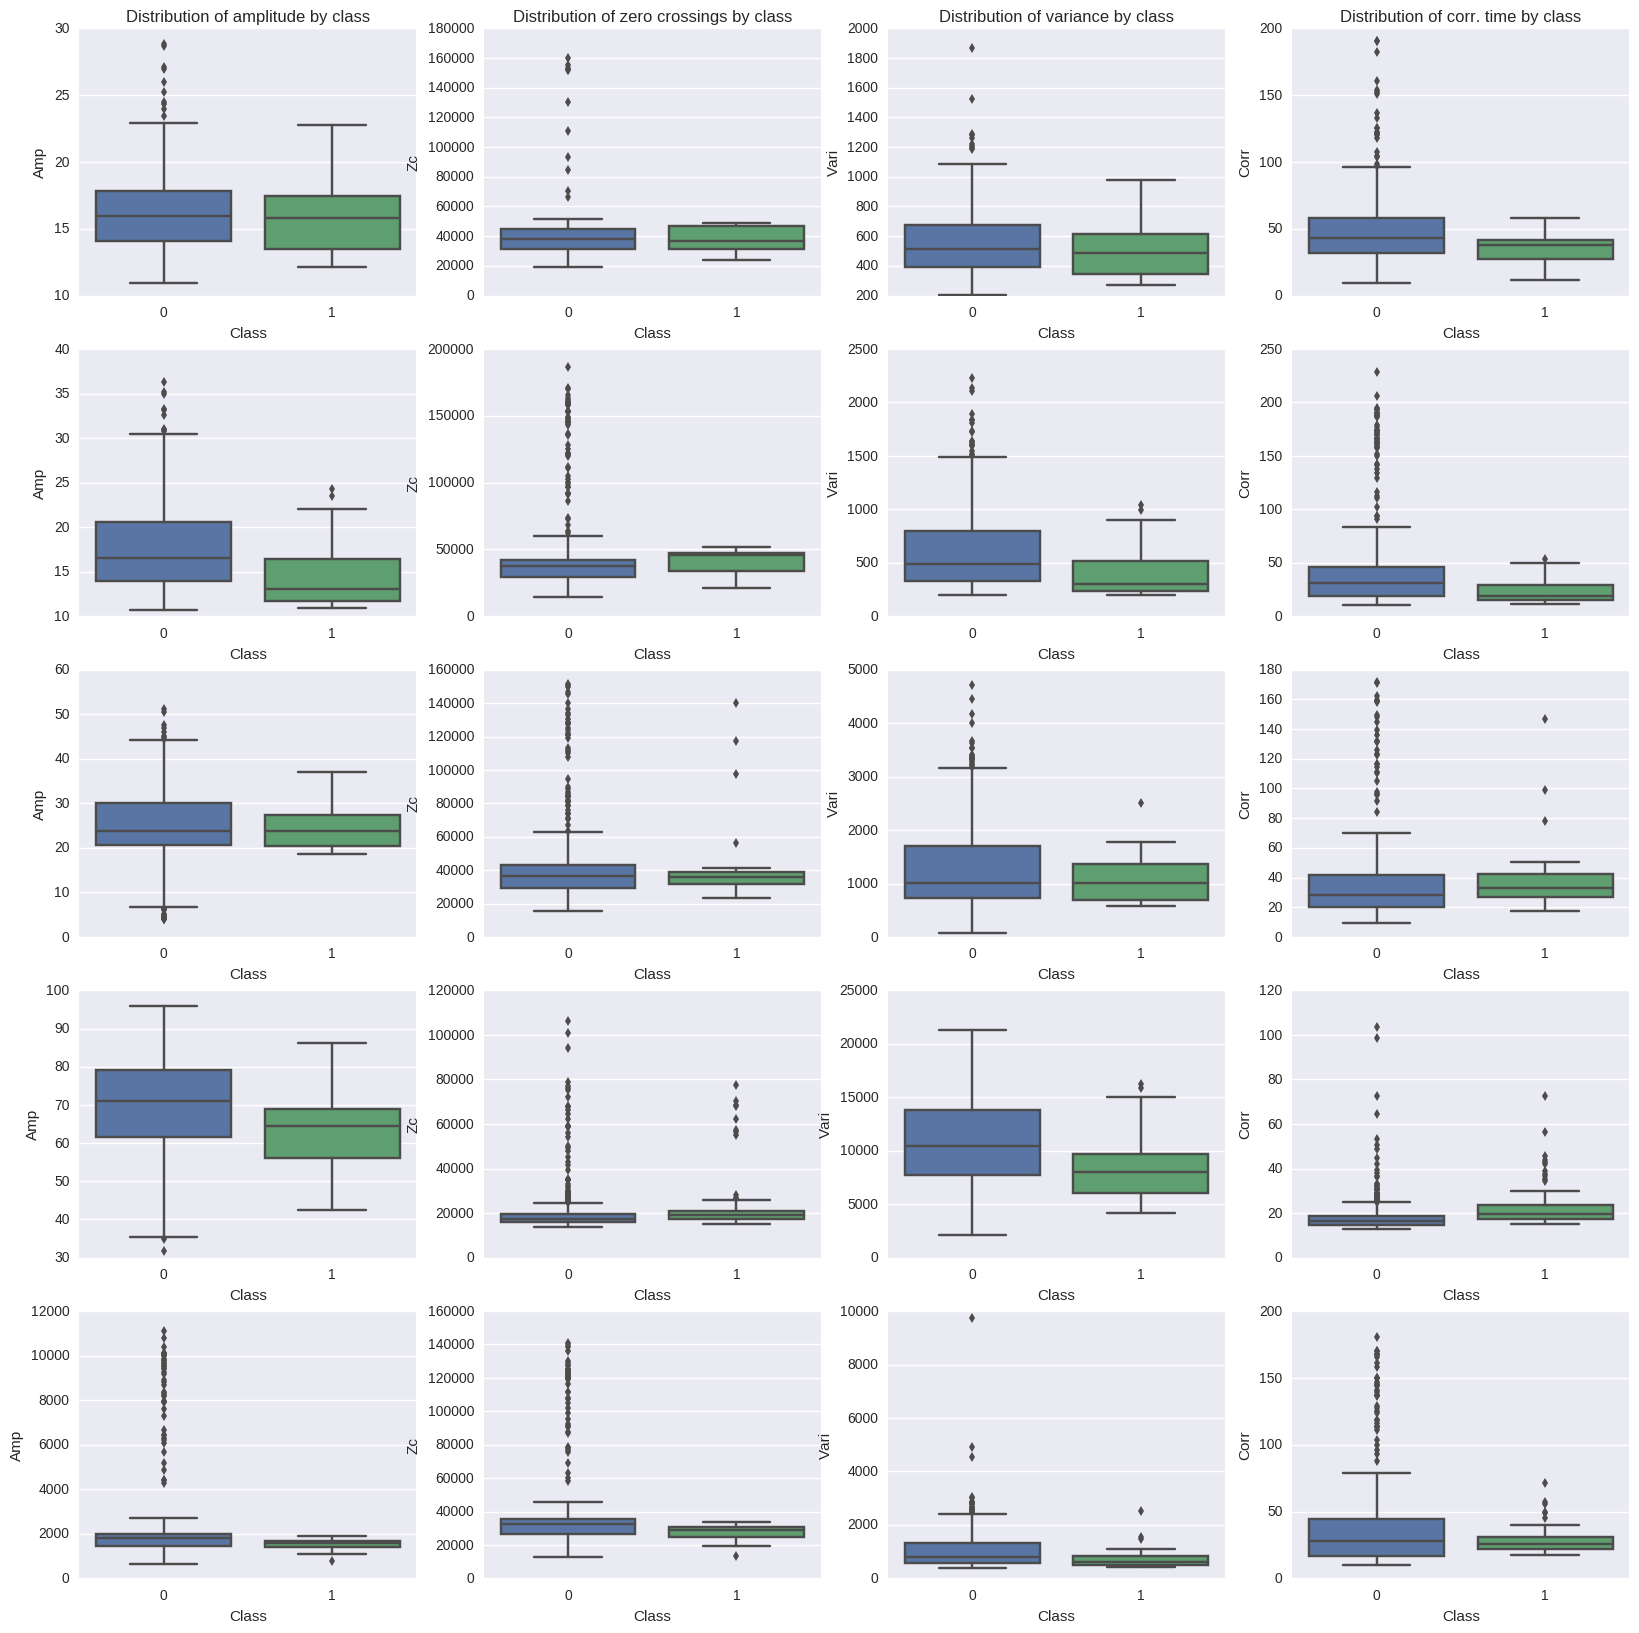

In [49]:
feature_distrib()

Indeed, when looking at each subject individually, one starts to distinguish differences in the features distribution. For some subjects-features combinations (i.e. Dog_4,variance / Dog_2,corr time), the difference is clearer than for others (i.e. Dog_1,zero crossings / Dog_3,amplitude). 

Not too surprisingly, this seems to indicate that the subjects should be treated separately. Indeed, there can be a lot of variations in the signals recorded from the brain of multiple subjects. The electrode placement, the noise of each channel, can have a great influence on which features are informative. It can also be noted that the breed of the different dogs is not specified, and that it may vary between subjects.

#### Frequency bands

In [ ]:
# Computing the band powers

#dataDir = 'Data/'
#features,info,labels = all_fft_feats(dataDir)

In [30]:
#labels = np.hstack(labels)

#featuresTemp = (features[0])
#for i in range(len(features)-1):
#    featuresTemp = np.vstack((featuresTemp,features[i+1]))
#featuresTemp.shape
#features = featuresTemp

#del featuresTemp

In [78]:
## Saving the features using pickle

#with open('f_band_save', 'wb') as f:
#    pickle.dump(features, f)
#with open('labels_band_save', 'wb') as f:
#    pickle.dump(labels, f)
#with open('info_band_save', 'wb') as f:
#    pickle.dump(info, f)

In [104]:
# Loading the saved features

with open('f_band_save', 'rb') as f:
    features = pickle.load(f)
with open('labels_band_save', 'rb') as f:
    labels = pickle.load(f)
with open('info_band_save', 'rb') as f:
    info = pickle.load(f)

Again, the global distribution does not show a clear trend differentitating the two classes.

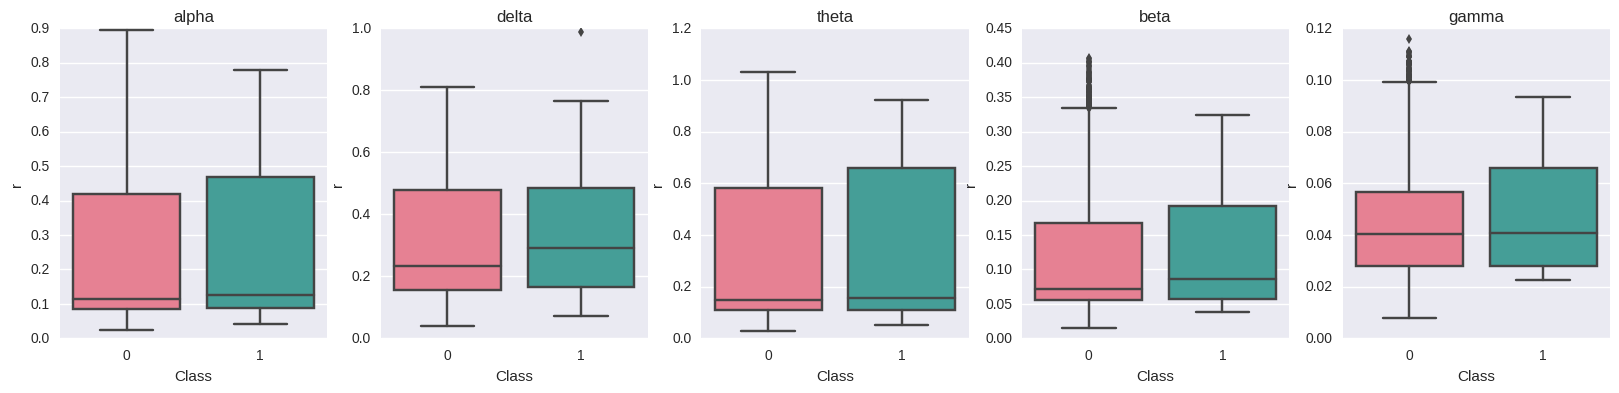

In [109]:
band_distrib_all()

And the distribution by subjects also has similar properties than before. 

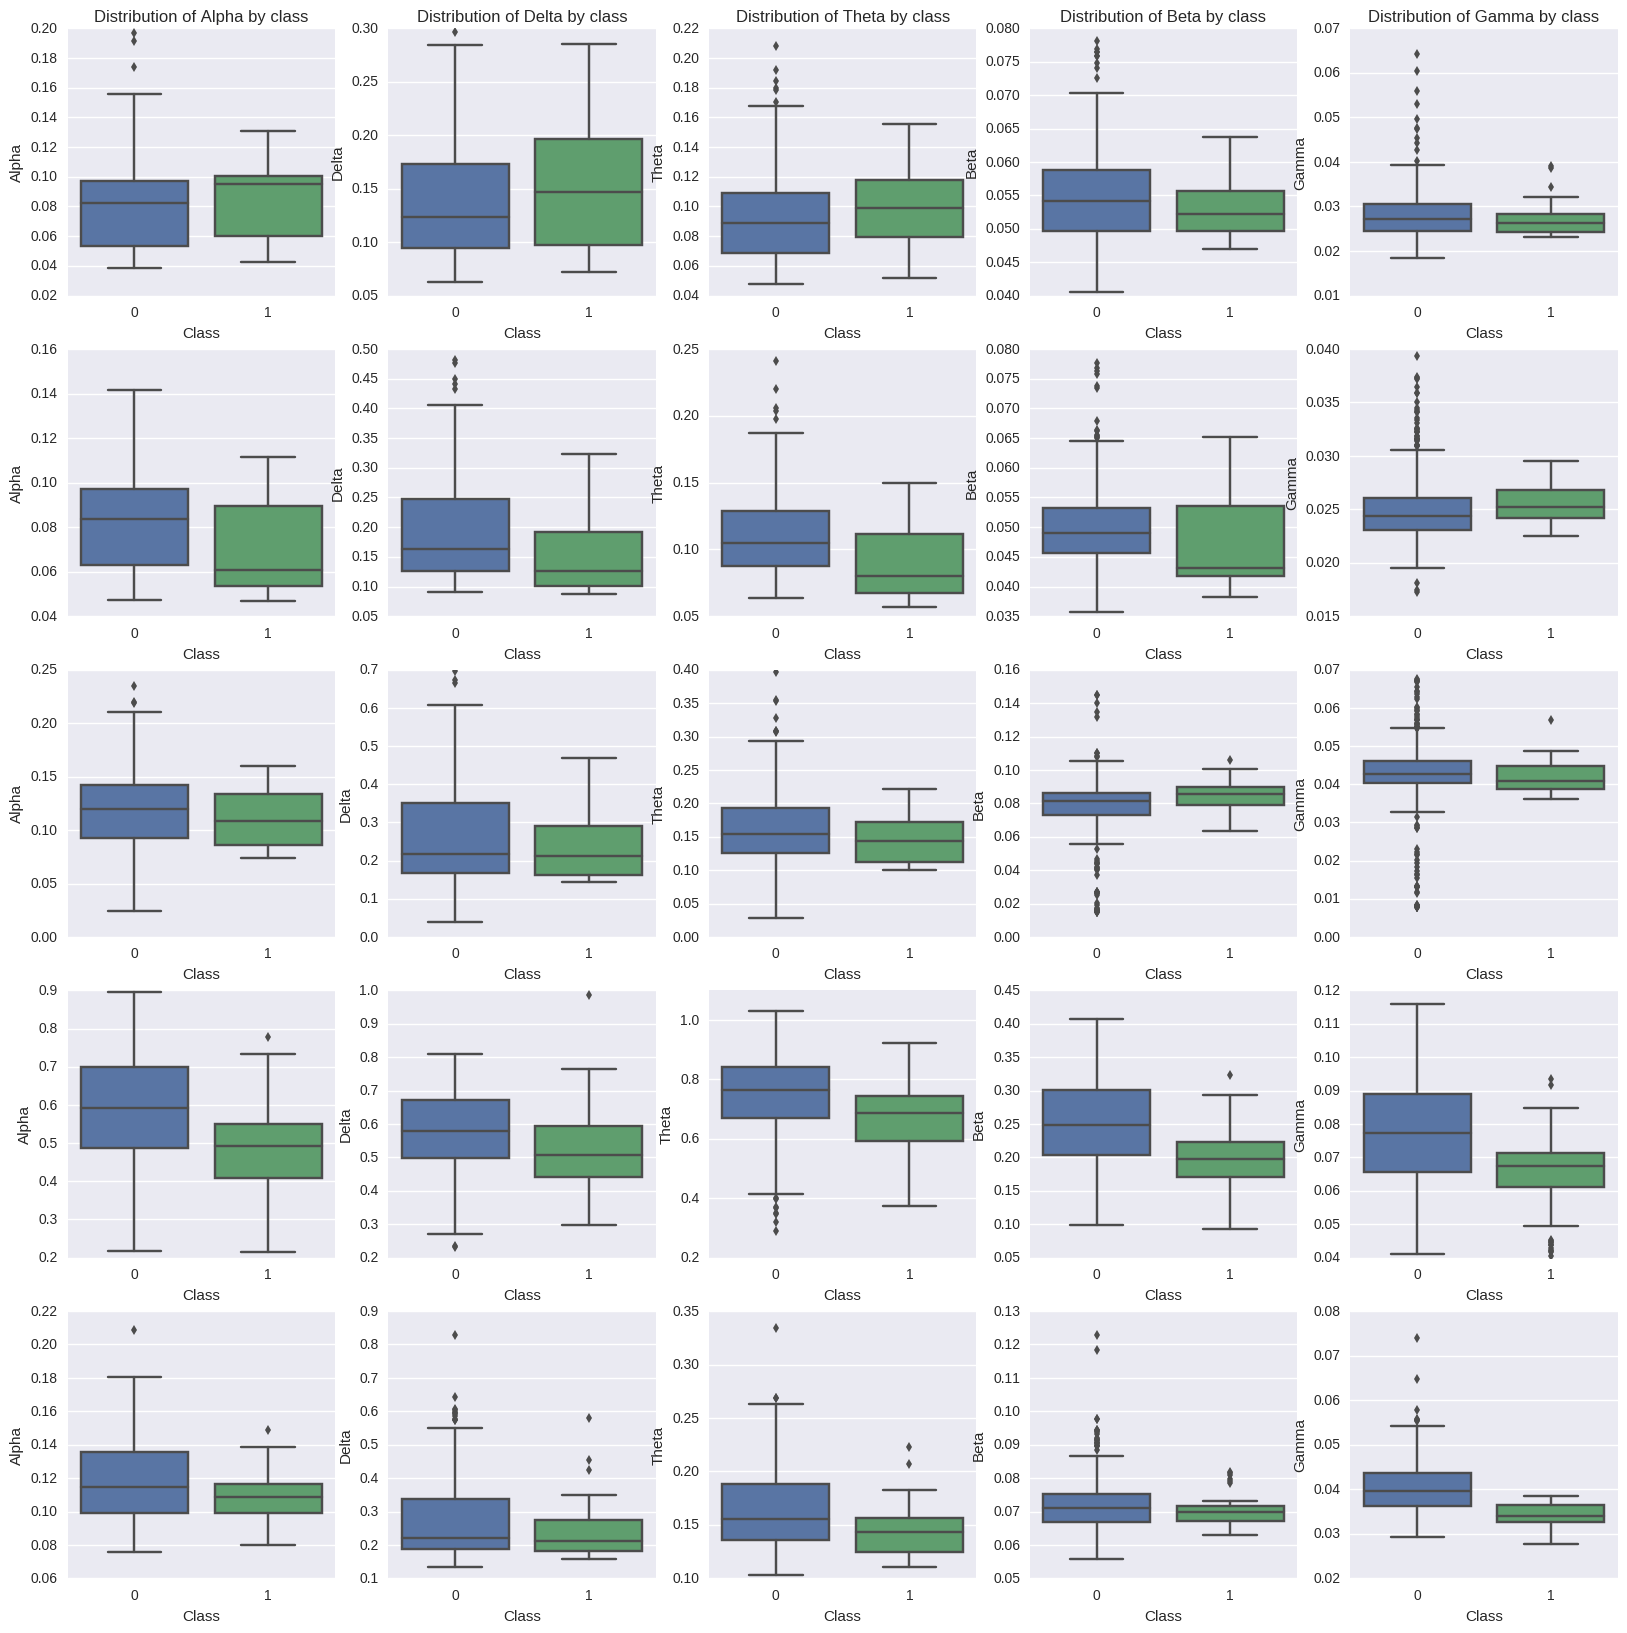

In [123]:
feature_band_distrib()

Overall, the different features seem to contain some information about the classes, but no single feature is sufficient to perform the classification. 

### Down-sampling
As each datapoint is quite big, computations might get heavy. A possible way to reduce size is to down-sample the recordings. For example taking only one sample out of 2, the size would get reduced by half, as well as the maximum frequency that can be represented in the signal. There is thus a price to pay for space saving.

In the graph below, the effects of down-sampling is shown on a fraction of an EEG recording.

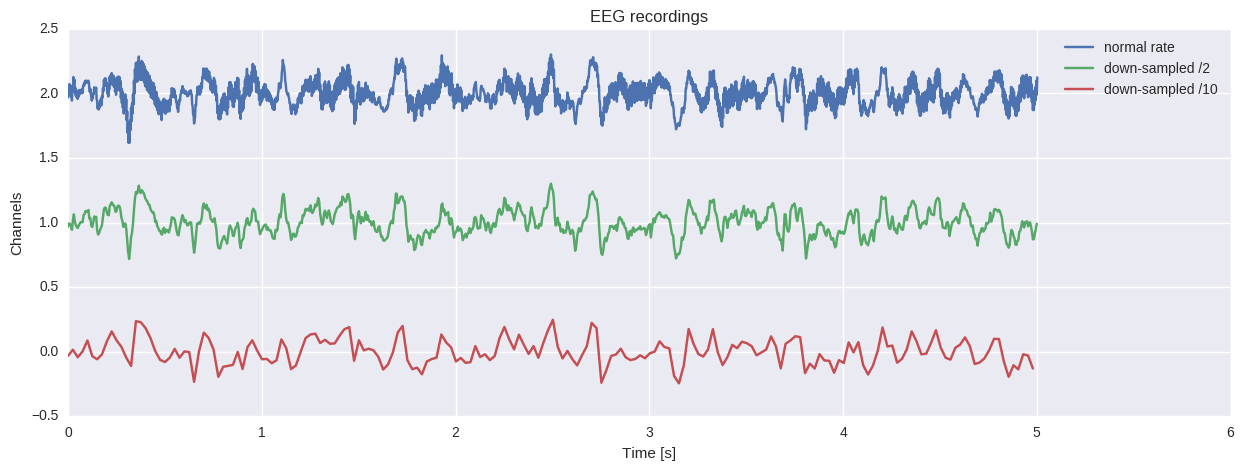

In [3]:
# Down-sampling
mats = sp.io.loadmat('Data/Dog_4/Dog_4_preictal_segment_0007.mat') 
chan = 0

key = list(mats)
sub = 'segment'
segKey = [s for s in key if sub in s]

numRows = mats[segKey[0]][0][0][0].shape[0]
numSamples = len(mats[segKey[0]][0][0][0][chan])

# Get sampling rate
fs = mats[segKey[0]][0][0][2][0]

t = range(0,numSamples)/fs

_,axes = plt.subplots(figsize=(15, 5)) 

data = mats[segKey[0]][0][0][0][chan]

to = 2000
plt.plot(t[:to:1],data[:to:1]/(2*np.max(data))+2,label='normal rate')
plt.plot(t[:to:2],data[:to:2]/(2*np.max(data))+1,label='down-sampled /2')
plt.plot(t[:to:10],data[:to:10]/(2*np.max(data)),label='down-sampled /10')

axes.set_title('EEG recordings');
axes.set_xlabel('Time [s]');
axes.set_ylabel('Channels');
handles, labelsFig = axes.get_legend_handles_labels()
axes.legend(handles, labelsFig,loc=1);


### AR parameters

Another way to analyse time series is to try to predict them by building a model, then taking taking the model parameters as features. One such method is tu use an auto-regressive (AR) model, and look at the AR parameters.

The module statsmodel contains a function "ARMA" that can be used to fit an AR model to a time serie. A small model order (3) was chosen, and data was downsampled with a factor 4 to ease the computations. However, fitting AR models to the 16 channels of all the segments still required more than 10 hours, and this method was discarded.

## 4. Data exploitation


### Dimensionality reduction

All the features described above are computed on individual channels. This gives rise to a relatively high total number of features (64 for the basic set, 80 for the frequency bands set). This can be problematic, as there is only a limited number of preictal segments (in average 46 per dog). With such a high amount of features, it is quite easy to train a classifier that will represent perfectly the training set, as each preictal point can be isolated. However, the classifier would not be able to generalize to new datapoints (overfitting).

It may thus be necessary to perform dimensionality reduction, either using feature selection, PCA, or other techniques.

In [142]:
# Loading the saved features

with open('f_band_save', 'rb') as f:
    features = pickle.load(f)
with open('labels_band_save', 'rb') as f:
    labels = pickle.load(f)
with open('info_band_save', 'rb') as f:
    info = pickle.load(f)

### Classifier

Different kinds of classifier were trained.

The training data was split in two, and a 2-folds cross-validation was performed. Using more folds would have reduced the number of preictal segments too much. For each iteration, the model is trained on the training fold, and tested on the validation fold.



In [186]:
# Defining models to test 
clf = []
clf.append(sklearn.neighbors.KNeighborsClassifier()) # k-NN classifier
clf.append(sklearn.svm.LinearSVC()) # linear SVM classifier
clf.append(sklearn.linear_model.LogisticRegression()) # logistic classifier
clf.append(sklearn.ensemble.RandomForestClassifier())
clf.append(sklearn.linear_model.RidgeClassifier())


names = ["KNN", "Lin.SVM", "logistic reg.", "Forest","Ridge"]

In [190]:
# Parameters to test
num_param = 50

K = np.asarray(range(1,num_param+1,1))
C_svm = np.logspace(-3,4,num_param)
C_regr = np.logspace(-3,5,num_param)
n_est = np.asarray(range(1,2*num_param+1,2))
alpha = np.logspace(-10,0,num_param)

param = np.vstack((K,C_svm,C_regr,n_est,alpha))

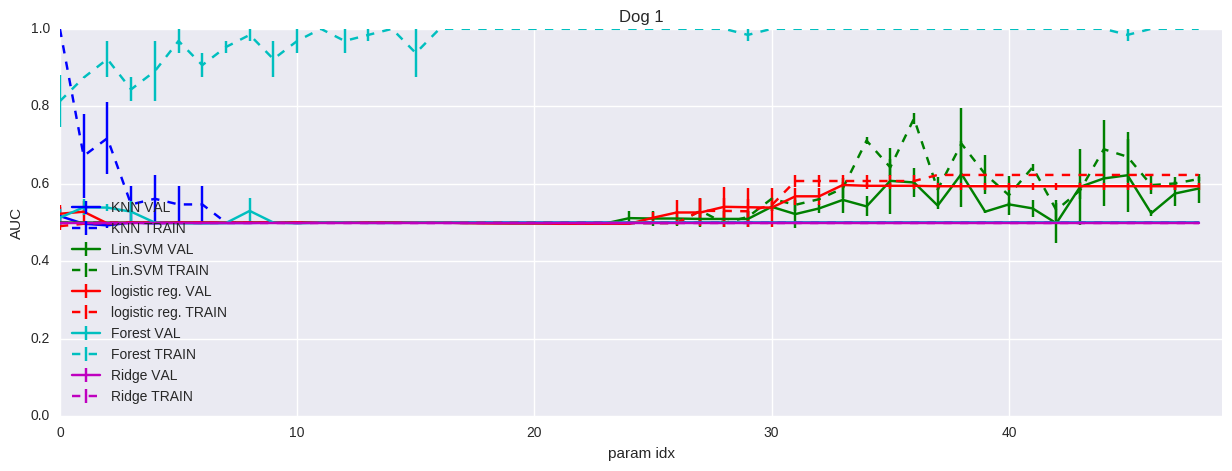

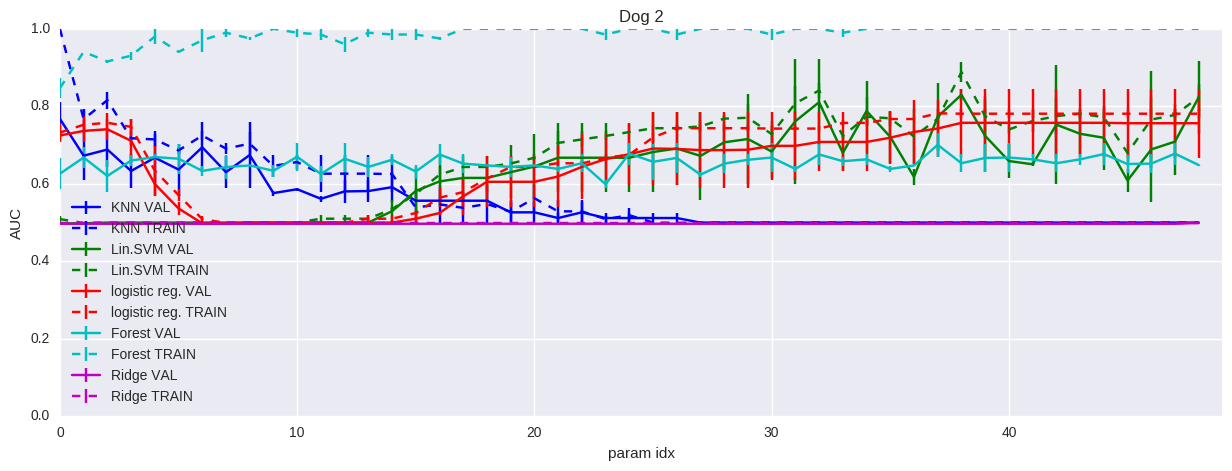

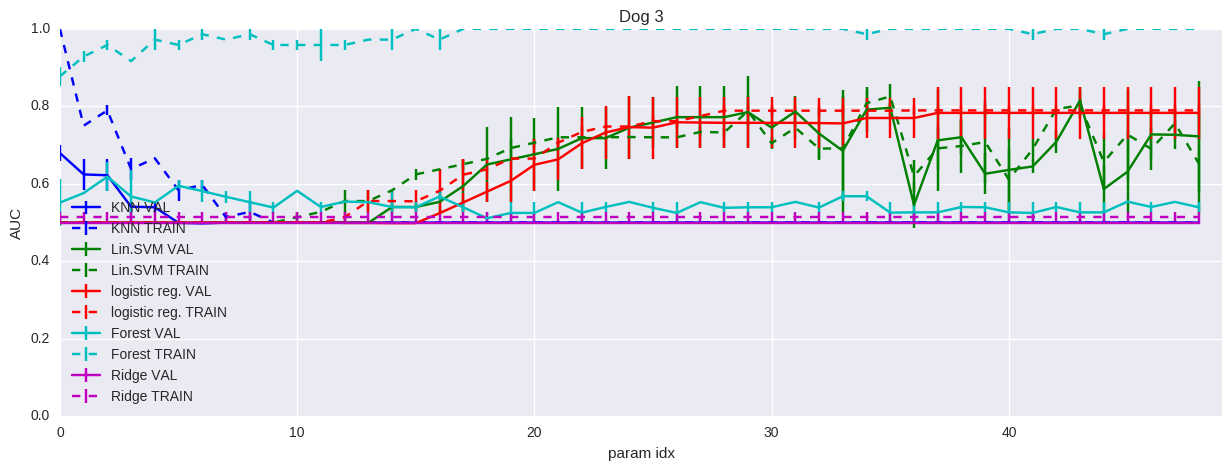

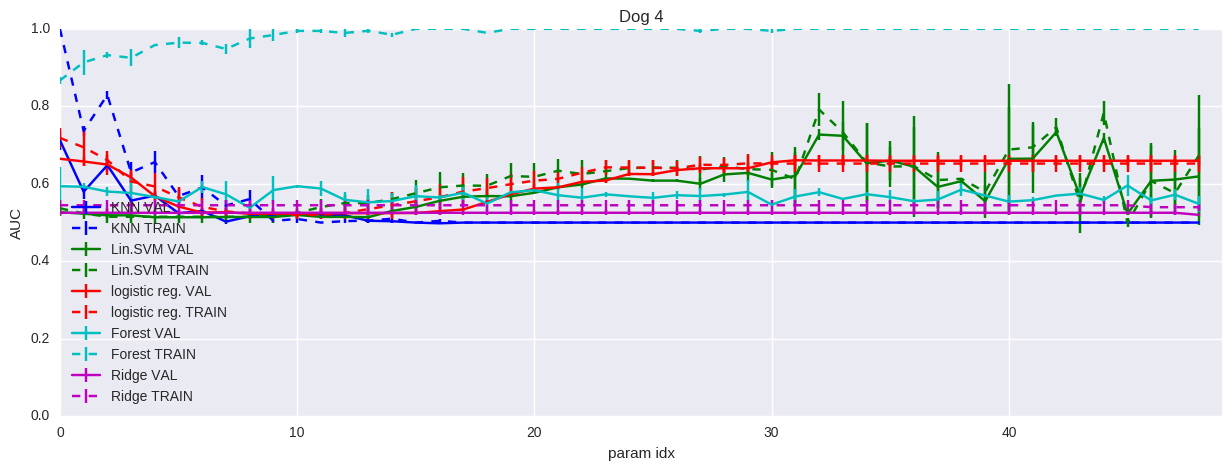

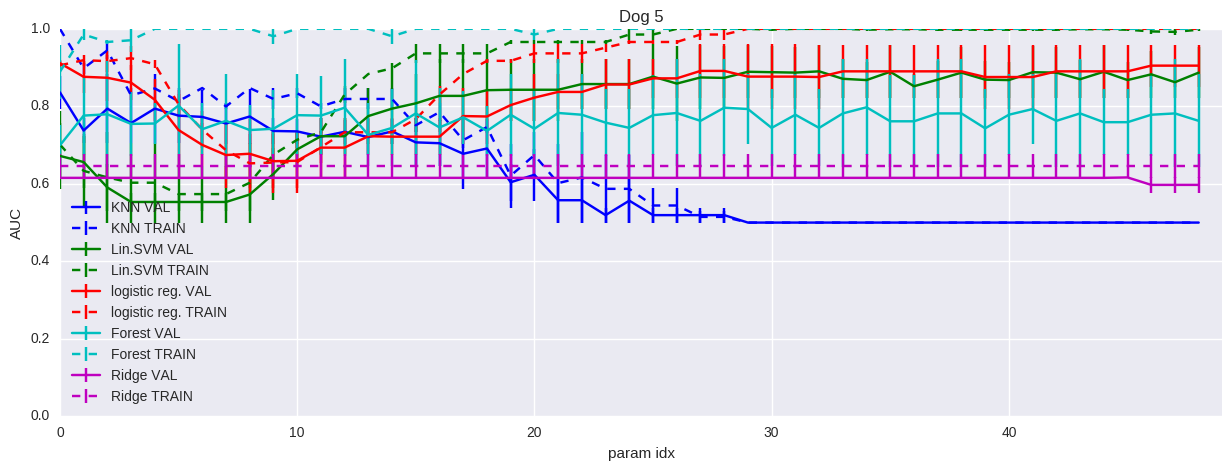

In [188]:
train_classifier_ALL(clf,names,param)

Among the tested classifiers, the logistic regression regularly had the best validation AUC. It was therefore selected. As already mentionned, there are a lot of features in comparison with the number of datapoints. Features were thus ranked according to the ANOVA F-value between them and the labels, and only the K best were included in the model.

A range of values of K was tested.

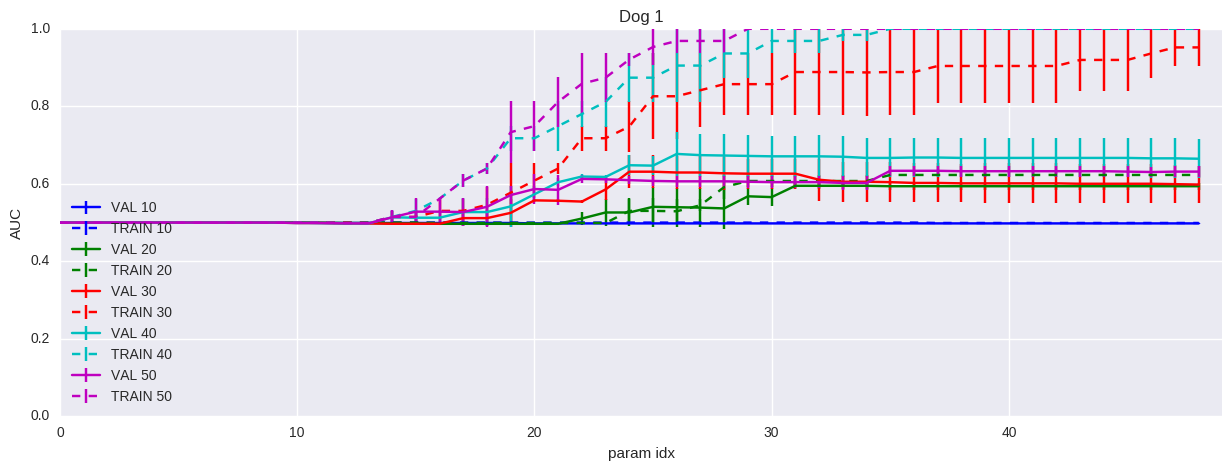

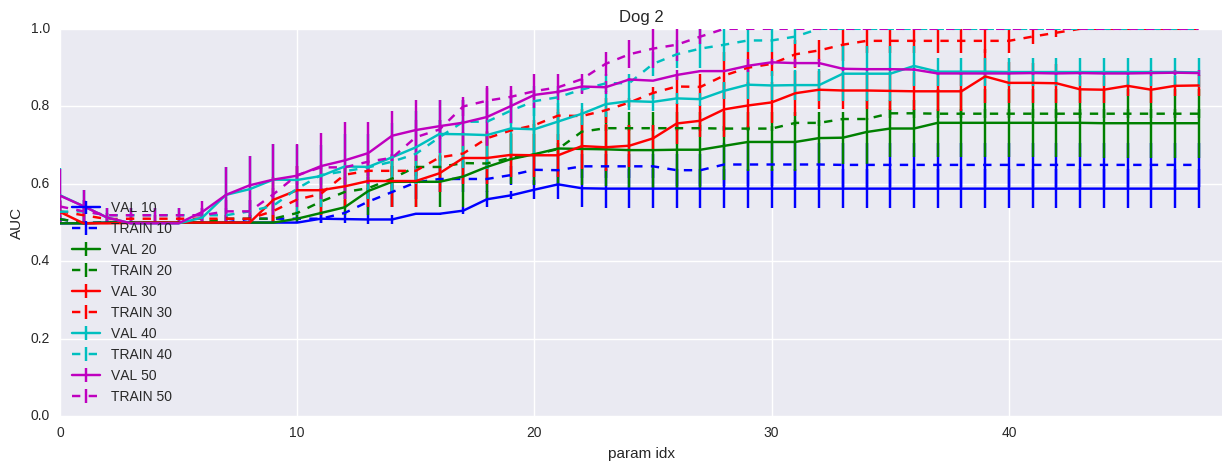

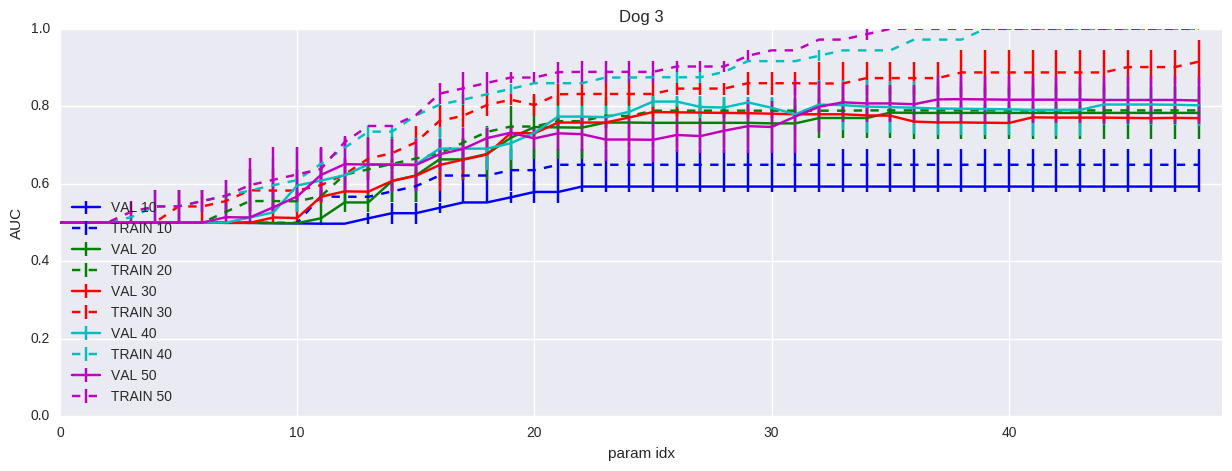

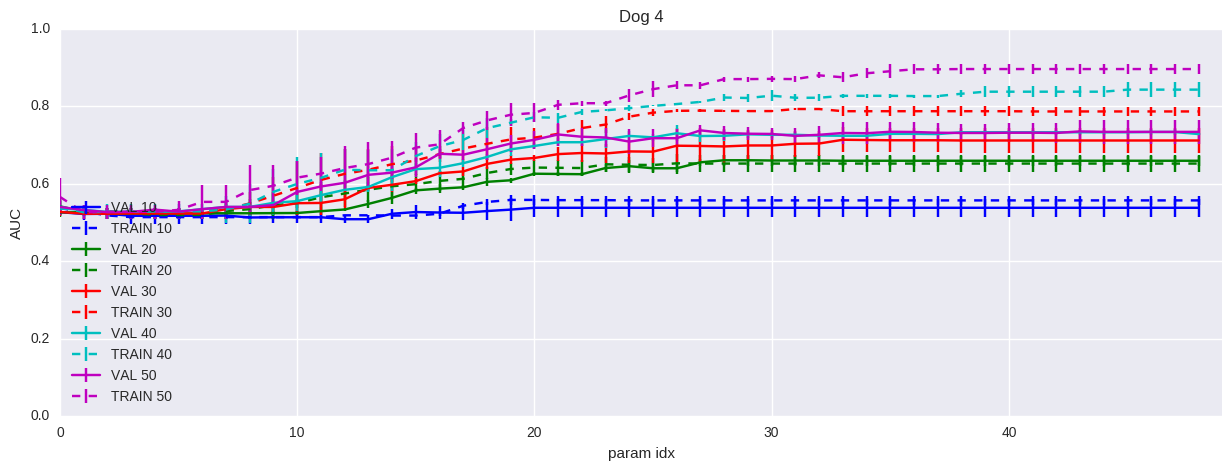

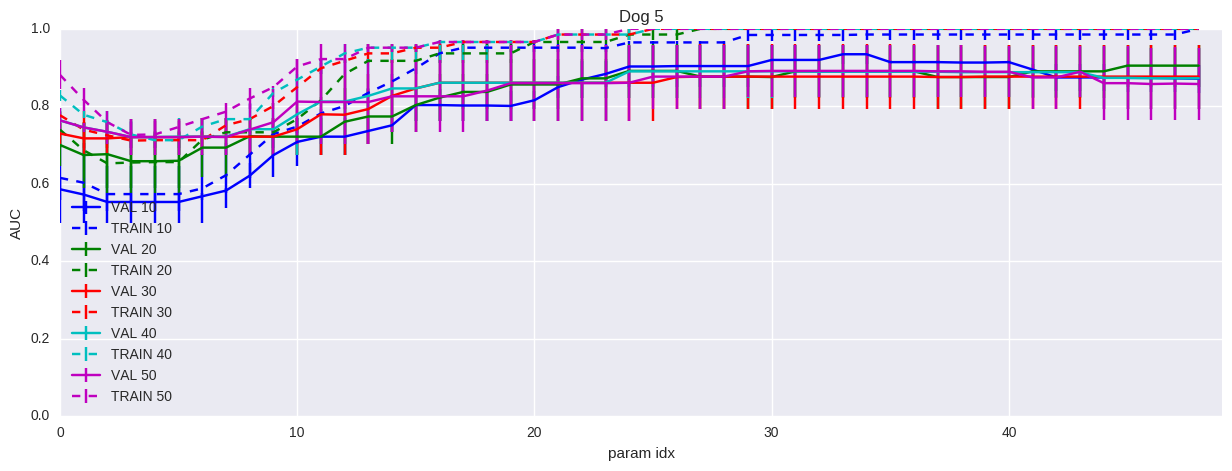

In [198]:
model = sklearn.linear_model.LogisticRegression()
param = np.logspace(-2,5,num_param)
name = ["logistic reg."]

train_classifier(model,name,param)

For most of the subjects, at least one value of K allows to fit the training set (AUC between 0.9 and 1). However, there may be a relatively great gap between the training and validation AUC. The validation AUC takes values between 0.6 (not really satisfying) and 0.9 (good prediction).

With a K of 20, the model is not able to learn the training set perfectly. However, the training and validation error are usually close to each other, showing an ability to generalize from one half of the training set to the other. This value was chosen rather than a higher one (representing better the training set), to try to avoid overfitting.

## 5. Evaluation
During the Kaggle competition, predictions had to be made for the unlabelled segments. Submissions were then evaluated by the Area Under the ROC Curve (AUC). Since the competition has been over for a long time, a _teacher's key_ has been published, with the actual labels of the test set. To respect the spirit of the game, this key was only used to compute the final performance of the developped models, as if submissions had been made on the Kaggle platform.

### About the AUC
The Receiver Operating Characteristic (ROC) curve is a measure of the performance of a binary classifier. The classifier output takes values between 0 and 1. By changing the threshold used for binarizing the results, one can change the balance between sensitivity and specificity. The ROC curve is the true positive rate against the false positive rate, for the different threshold values. The AUC is the area under this curve, and should range between 0.5 (chance level) and 1 (perfect classification).
<figure>
    <img src="Roccurves.png" alt="Drawing" style="width: 300px;"/>
    <figcaption> Examples of ROC curves. </figcaption>
    <cite>By BOR at the English language Wikipedia, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=10714489</cite>
</figure>

For this dataset, the AUC is a convenient way to compensate for the large unbalance of the classes. Indeed, by predicting only the majoritary class, one would alredy get an accuracy over 0.9 which is not really meaningful, while the AUC would be 0.5.


### Results

The retained model is the logistic regression classifier, keeping 20 features. It is trained on the whole training set of each dog, and tested on each unlabelled set.

In [205]:
# Training + getting predicted labels
model = sklearn.linear_model.LogisticRegression()
p = param[30]

pred_test, info_test, accuracytrain = test_classifier(model,p)
print('Training AUC :\n',accuracytrain)

Training AUC :
 [0.60104166666666659, 0.75690476190476186, 0.78880133715377276, 0.65748576704108319, 1.0]


In [203]:
# Compute test AUC (from teacher's key published on Kaggle's forum)
filename_csv = 'SzPrediction_answer_key.csv'
labels_csv = pd.read_csv(filename_csv, index_col=0)

for j in range(5):
    labels_test = []
    for i in range(pred_test[j].shape[0]):
        # get segment name
        seg_name = info_test[j][i]

        # get entry of csv corresponding to name
        l = labels_csv.loc[seg_name].loc['preictal']

        # append to labels_test_num
        labels_test.append(l)

    # compute AUC
    testAUC = sklearn.metrics.roc_auc_score(np.asarray(labels_test), pred_test[j])
    print('Test AUC : ', testAUC)

Test AUC :  0.603992329149
Test AUC :  0.64590964591
Test AUC :  0.53891509434
Test AUC :  0.609804253399
Test AUC :  0.421787709497


The results on the test sets are not really satisfying. For the $5^{th}$ dog, the prediction is even worse than chance level, even though the training set was fitted perfectly (overfitting). For the first dog, train and test AUC are pretty close to each other, but relatively low. For the other dogs, there is a consequent gap between training and testing AUC, even though not as striking as for Dog_5.

The implemented method did not allow to separate the preictal segments from the interictal ones.

## 6. Potential improvements

The tuning of the different parameters of the models and of the number of features included could be performed in a finer way. However, this would probably not be sufficient to have an important AUC improvement.

Other kinds of features could be extracted (AR parameters, wavelets, ...), which could contain more information about the class of the segments. And dimensionality reduction could be performed using PCA, or sequential feature selection.

Another approach could be to be to avoid extracting features, and use directly the time series as inputs. This would thus require less human intervention in the model, letting it learn everything. For example, a convolutional neural network (CNN) could be used. Similarly to what is done for images, the network would be trained, and would learn a series of filters. The difference being that those filters would be defined only on one dimension, along the time axis, to take into acounts samples from one electrode at a time. This method was tried, but loading all the EEG recordings of a subject (even with downsampling) and training a CNN required too much RAM for it to work properly. 

Finally, if the electrode locations were available, it would maybe be possible to see the problem as a graph. Each electrode would be a node, and the EEG recordings could be seen as one signal defined over the 16 nodes. This would add a spatial dimension to the problem, and might ellicit the use of other analysis methods.